In [1]:
library(tidyverse)
library(readxl)
library(ggplot2)
library(cowplot)
library(tidymodels)
library(repr)
library(dplyr)
library(gridExtra)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
“package ‘cowplot’ was built under R version 4.3.2”

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1

### Predictive Analytics for Knowledge Level Assessment: An Integrated Approach Using Classification and Performance Metrics

#### Introduction:

Classification is a type of machine learning model that predicts the 'class' of the inputted data. Here we are looking to classify students' knowledge levels (Very Low, Low, Middle, High) based on their specific study and performance metrics. The model created here will be done through supervised machine learning, in which a 'training_set' will be used to fit a model whose efficacy will be tested using the 'testing_set.' The 'User Knowledge Modeling' database contains information about students' degree of study time on goal materials (STG) and related goal materials (STR), exam performance of goal materials (PEG) and related goal materials (LPR), the degree of repetition of goal materials (SCG), and their knowledge level (UNS). First, we will create a model that uses inputs of degree of study time and exam performance of goal material only (STG, PEG). We will create a second model that uses information of degree of study time and exam performance for both the goal materials and related goal materials (STG, PEG, STR, LPR). Finally, we will compare the efficacy of these two models and determine how, if at all, the related goal material contributes to the outcome (student knowledge level).

`STG` The degree of study time for goal object materials

`STR` The degree of study time of user for related objects with goal object

`LPR` The exam performance of user for related objects with goal object

`PEG` The exam performance of user for goal objects

>By analyzing this dataset, we aim to clearly discern the classification of users' knowledge levels across the defined categories: *very_low, Low, Middle, and High*. Understanding these knowledge levels is crucial for optimizing educational strategies and interventions in this particular subject.

This will ultimately answer our research question:


##### How do metrics of related goal materials contribute to metrics of goal based metrics on the prediction of overall knowlegde?


#### Methods:
Our data analysis approach focuses on selecting relevant variables for classification using the k-nearest neighbors (k-NN) algorithm. Specifically, we utilize four predictors: STG, STR, PEG, and LPR (as defined in the introduction), which serve as predictors of an individual’s knowledge level. The dataset was initially subjected to data cleaning, resulting in six columns—five representing standardized measurements and one serving as a categorical label for the user's knowledge level per observation. Given our research question, which examines whether study time for related object materials significantly predicts knowledge level in goal-oriented materials, only four of these columns were deemed necessary for our analysis.

In preparation for classification, we divided our dataset into training and testing sets. This split facilitates training our k-NN model on one portion of the data while evaluating its performance on an independent set to assess generalization capabilities.

Our analytical process began by employing all four predictors to establish a baseline accuracy for predicting the user's knowledge level. We then conducted a comparative analysis by excluding variables related to time spent studying and performance on exams for related subjects. This allowed us to discern the impact of these variables by comparing the predictive accuracies between the comprehensive model and a reduced model.

To visualize and assess the classification results, we will use a confusion matrix. This matrix will provide a detailed view of the model's performance, showcasing the counts of true positives, true negatives, false positives, and false negatives for each class within the knowledge level category. This visualization aids in understanding the effectiveness of our k-NN classification approach across different knowledge levels, offering clear insights into the predictive accuracy of our model.

In [2]:
set.seed(1)
url <- "https://archive.ics.uci.edu/static/public/257/user+knowledge+modeling.zip"
temp <- tempfile()
temp2 <- tempfile()

download.file(url, temp)
unzip(zipfile = temp, exdir = temp2)
data_training <- read_excel(file.path(temp2, "Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls"), sheet = 2) #training data
data_testing <- read_excel(file.path(temp2, "Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls"), sheet = 3)  #testing data
unlink(c(temp, temp2))


knowledge_testing <- select(data_testing, STG:UNS) |>
    mutate(UNS = as_factor(UNS)) |>
    mutate(UNS = factor(UNS, levels = c("Very Low", "High", "Low", "Middle")))

knowledge_training <- select(data_training, STG:UNS) |> #selected useful columns
    mutate(UNS = as_factor(UNS)) |>
    mutate(UNS = recode(UNS, very_low = "Very Low")) |>
    mutate(UNS = factor(UNS, levels = c("Very Low", "High", "Low", "Middle")))
slice(knowledge_training, 1:10) #sliced so as not to clog screen 

summary_knowledge_training <- knowledge_training |>   # this table shows the total amount of observations per knowledge lvl
    group_by(UNS) |>                                  # and the mean values for each predictor for each knowledge lvl
    summarize(count = n(),
             STG_mean = mean(STG),
             STR_mean = mean(STR),
             LPR_mean = mean(LPR),
             PEG_mean = mean(PEG))

summary_knowledge_training

New names:
• `` -> `...7`
• `` -> `...8`
New names:
• `` -> `...7`
• `` -> `...8`


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,Very Low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle
0.10,0.10,0.43,0.29,0.56,Middle
0.15,0.02,0.34,0.40,0.01,Very Low
0.20,0.14,0.35,0.72,0.25,Low


UNS,count,STG_mean,STR_mean,LPR_mean,PEG_mean
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Very Low,24,0.3057917,0.3662500,0.3587500,0.09083333
High,63,0.4216508,0.5016667,0.5012698,0.77253968
Low,83,0.3211446,0.4307229,0.4973494,0.23762651
Middle,88,0.3999773,0.5068182,0.3428409,0.54238636


#### Expected outcomes and significance:
We anticipate that our analysis will demonstrate a significant correlation between the study time devoted to related subjects and exam performance on these subjects with the overall knowledge level of the user. Specifically, we hypothesize that increased study time and better exam results for related materials will be associated with higher knowledge levels in goal-oriented materials. This expectation is grounded in educational theories that suggest integrative learning and cross-contextual application of knowledge can enhance comprehension and retention of information, thereby improving performance in related assessments.

Our comparative analysis of the full model versus the reduced model should reveal that excluding the predictors related to study time and exam performance for related subjects diminishes the model’s accuracy. If our hypothesis holds true, the results will underscore the importance of these factors in predicting and understanding an individual's knowledge level. Ultimately, this could lead to recommendations for educational strategies that emphasize the interconnectedness of subject materials to maximize learning outcomes.

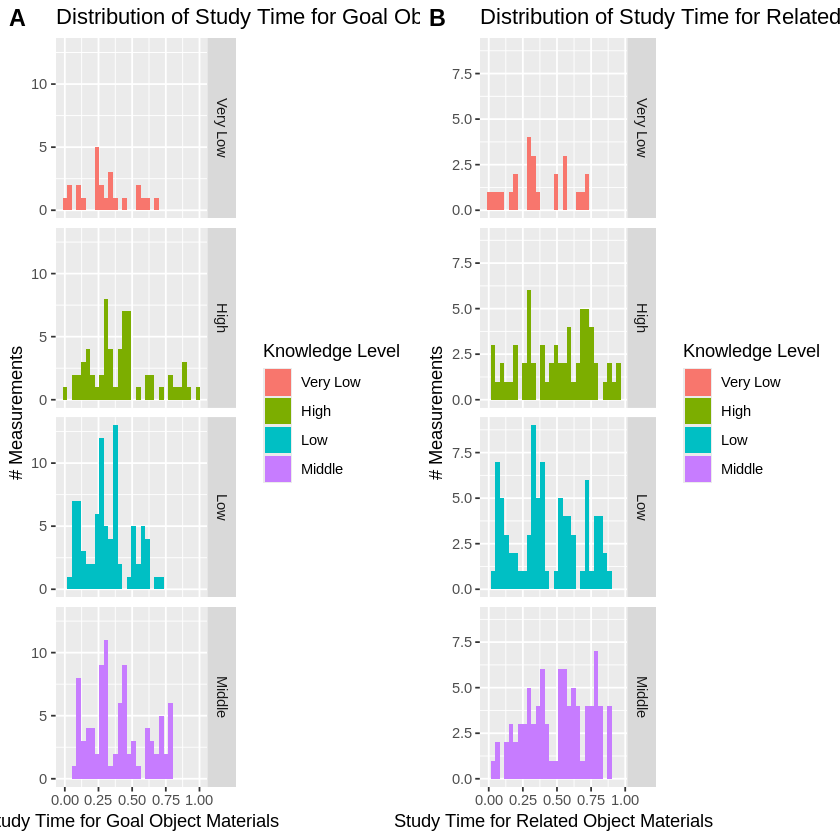

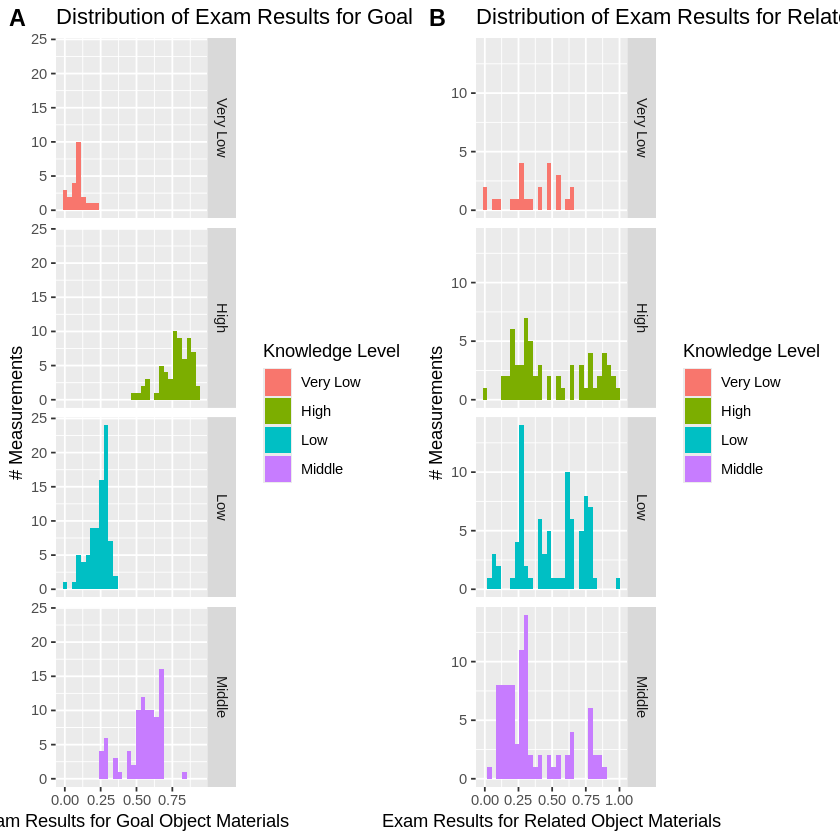

In [3]:

# Plot for Study Time for Goal Object Materials
knowledge_STG_hist <- ggplot(knowledge_training, aes(x = STG, fill = as_factor(UNS))) +
  geom_histogram(bins = 30) +  # You may adjust the number of bins as needed
  facet_grid(rows = vars(UNS)) +
  labs(x = "Study Time for Goal Object Materials", y = "# Measurements", fill = "Knowledge Level") +
  ggtitle("Distribution of Study Time for Goal Object Materials by Knowledge Level")

# Plot for Study Time for Related Object Materials
knowledge_STR_hist <- ggplot(knowledge_training, aes(x = STR, fill = as_factor(UNS))) +
  geom_histogram(bins = 30) +
  facet_grid(rows = vars(UNS)) +
  labs(x = "Study Time for Related Object Materials", y = "# Measurements", fill = "Knowledge Level") +
  ggtitle("Distribution of Study Time for Related Object Materials by Knowledge Level")

# Plot for Exam Results for Goal Object Materials
knowledge_PEG_hist <- ggplot(knowledge_training, aes(x = PEG, fill = as_factor(UNS))) +
  geom_histogram(bins = 30) +
  facet_grid(rows = vars(UNS)) +
  labs(x = "Exam Results for Goal Object Materials", y = "# Measurements", fill = "Knowledge Level") +
  ggtitle("Distribution of Exam Results for Goal Object Materials by Knowledge Level")

# Plot for Exam Results for Related Object Materials
knowledge_LPR_hist <- ggplot(knowledge_training, aes(x = LPR, fill = as_factor(UNS))) +
  geom_histogram(bins = 30) +
  facet_grid(rows = vars(UNS)) +
  labs(x = "Exam Results for Related Object Materials", y = "# Measurements", fill = "Knowledge Level") +
  ggtitle("Distribution of Exam Results for Related Object Materials by Knowledge Level")

# Combine the first two plots into a grid
grid1 <- plot_grid(knowledge_STG_hist, knowledge_STR_hist, labels = "AUTO")

# Combine the last two plots into a grid
grid2 <- plot_grid(knowledge_PEG_hist, knowledge_LPR_hist, labels = "AUTO")

# Optionally, if you want to view these combined grids in the R environment
print(grid1)
print(grid2)


#### Results:

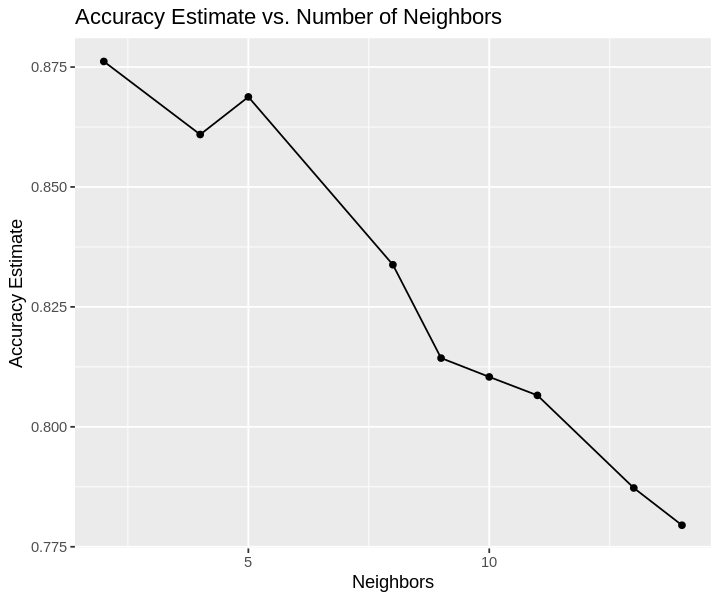

In [4]:
# Set seed for reproducibility and plotting options
set.seed(1)
options(repr.plot.width = 6, repr.plot.height = 5)



# Prepare cross-validation with 5 folds stratified by knowledge level
knowledge_vfold <- vfold_cv(knowledge_training, v = 5, strata = UNS)

# Define the k-NN model specification with tuning
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# Create a recipe for preprocessing the data
knowledge_recipe <- recipe(UNS ~ STG + STR + PEG + LPR, data = knowledge_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Perform the tuning of the k parameter
knn_results <- workflow() |>
    add_recipe(knowledge_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = knowledge_vfold, grid = 10) |>
    collect_metrics()

# Filter for accuracy metrics and plot accuracy against number of neighbors
accuracies <- knn_results |>
    filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracy Estimate vs. Number of Neighbors")

print(accuracy_vs_k, title = "K-NN Model Accuracy Analysis")

# Find the best k value
best_k <- accuracies |>
    arrange(desc(mean)) |>
    slice_head(n = 1) |>
    pull(neighbors)

# Define model specification with the best k value
knowledge_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

# Fit the final model to the training data
knowledge_fit <- workflow() |>
    add_recipe(knowledge_recipe) |>
    add_model(knowledge_spec) |>
    fit(data = knowledge_training) 

# Make predictions on the testing set and evaluate accuracy
knowledge_predictions <- predict(knowledge_fit, knowledge_testing) |>
    bind_cols(knowledge_testing)

accuracy_metrics <- knowledge_predictions |>
    metrics(truth = UNS, estimate = .pred_class) |>
    filter(.metric == "accuracy")|> pull(.estimate)





#### Confusion Matrix:
The Confusion Matrix of the predictions using both goal-oriented and related material measurements:

In [5]:
# Create and print the confusion matrix
knowledge_confusion <- knowledge_predictions |>
    conf_mat(truth = UNS, estimate = .pred_class)

print(knowledge_confusion, title = "Confusion Matrix for Knowledge Level Prediction")


          Truth
Prediction Very Low High Low Middle
  Very Low       20    0   1      0
  High            0   39   0      1
  Low             6    0  38      3
  Middle          0    0   7     30


#### Accuracy:
The accuracy of the predictions using both goal-oriented and related material measurements:

In [6]:
print(accuracy_metrics)


[1] 0.8758621


#### Analysis with related subject excluded:

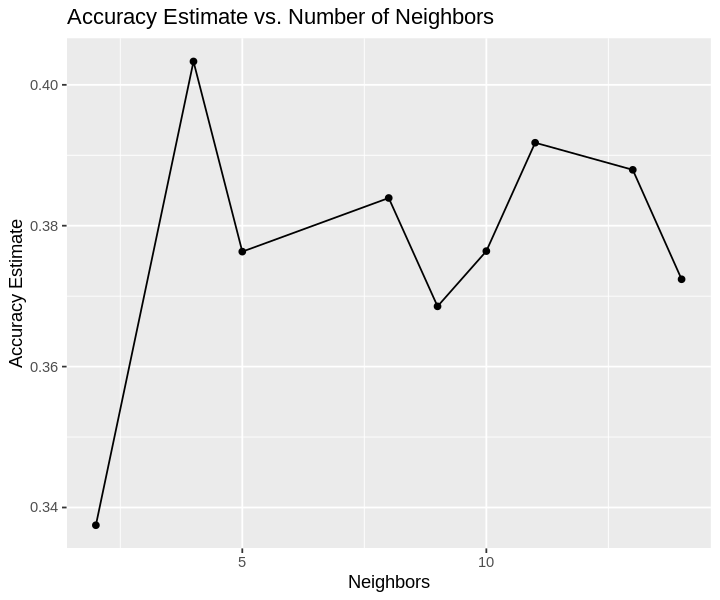

In [7]:
# Set seed for reproducibility and plotting options
set.seed(1)
options(repr.plot.width = 6, repr.plot.height = 5)



# Prepare cross-validation with 5 folds stratified by knowledge level
knowledge_vfold_2 <- vfold_cv(knowledge_training, v = 5, strata = UNS)



# Create a recipe for preprocessing the data
knowledge_recipe_2<- recipe(UNS ~ STG + STR , data = knowledge_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Perform the tuning of the k parameter
knn_results_2 <- workflow() |>
    add_recipe(knowledge_recipe_2) |>
    add_model(knn_spec) |>
    tune_grid(resamples = knowledge_vfold_2, grid = 10) |>
    collect_metrics()

# Filter for accuracy metrics and plot accuracy against number of neighbors
accuracies_2 <- knn_results_2 |>
    filter(.metric == "accuracy")

accuracy_vs_k_2 <- ggplot(accuracies_2, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracy Estimate vs. Number of Neighbors")

print(accuracy_vs_k_2, title = "K-NN Model Accuracy Analysis")

# Find the best k value
best_k_2 <- accuracies |>
    arrange(desc(mean)) |>
    slice_head(n = 1) |>
    pull(neighbors)

# Define model specification with the best k value
knowledge_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_2) |>
    set_engine("kknn") |>
    set_mode("classification")

# Fit the final model to the training data
knowledge_fit_2 <- workflow() |>
    add_recipe(knowledge_recipe_2) |>
    add_model(knowledge_spec_2) |>
    fit(data = knowledge_training) 

# Make predictions on the testing set and evaluate accuracy
knowledge_predictions_2 <- predict(knowledge_fit_2, knowledge_testing) |>
    bind_cols(knowledge_testing)

accuracy_metrics_2 <- knowledge_predictions_2 |>
    metrics(truth = UNS, estimate = .pred_class) |>
    filter(.metric == "accuracy")|> pull(.estimate)





#### Confusion Matrix:
The Confusion Matrix of the predictions using only goal-oriented material measurements:

In [9]:
# Create and print the confusion matrix
knowledge_confusion_2 <- knowledge_predictions_2 |>
    conf_mat(truth = UNS, estimate = .pred_class)

print(knowledge_confusion_2, title = "Confusion Matrix for Knowledge Level Prediction")

          Truth
Prediction Very Low High Low Middle
  Very Low        6    3   3      1
  High            8   14   7      7
  Low             7    9  21      9
  Middle          5   13  15     17


#### Accuracy:
The accuracy of the predictions using only goal-oriented material measurements:

In [10]:
print(accuracy_metrics_2)

[1] 0.4


#### Dicussion:
Not surprisingly, by analyzing the image above we found a positive correlation between the time spent studying for the exam and the level of knowledge of the individual. This also means that the large amount of time invested upfront is not useless, but will lead to better grades and more memorable knowledge for the user. However, we suddenly realized that good grades are not only achieved by spending a lot of time studying, because inefficient study methods and lack of concentration still lead to low grades and poor knowledge, and the positive correlation shown in the dataset actually includes many other intrinsic and extrinsic factors.
In order to support our argument, through reading related literature and deeper reflection, we believe that while the cost of time invested is important, it is equally important for college students to manage and plan their time wisely (Wolters et al, 2021). Efficiently utilizing a large amount of time for learning is what drives the strong correlation between grades and time spent studying. In that article, the authors specifically analyzed the importance of self-regulation strategies and time management among college students, both of which have had significant impacts including, but not limited to, reducing procrastination and improving academic performance. At the same time, the article also certifies that a certain amount of time commitment does have a positive impact on exam performance.

In that article, the authors specifically analyzed the importance of self-regulation strategies and time management among college students, both of which have had significant impacts including, but not limited to, reducing procrastination and improving academic performance. Also, the article agrees that a certain amount of time commitment does have a positive impact on test performance. While it is true that we have come to a positive conclusion by analyzing the dataset, while undoubtedly giving full guidance and confidence to college students who are preparing for their final exams, it is crucial to note that after analyzing the data through careful reflection, the data provided by the users did not demonstrate their self-regulation and wise study strategies, which are the additional factors hidden behind the positive correlation.


#### Citations:

Kahraman,Hamdi, Colak,Ilhami, and Sagiroglu,Seref. (2013). User Knowledge Modeling. UCI Machine Learning Repository. https://doi.org/10.24432/C5231X.

Wolters, C.A., Brady, A.C. College Students’ Time Management: a Self-Regulated Learning Perspective. Educ Psychol Rev 33, 1319–1351 (2021). https://doi.org/10.1007/s10648-020-09519-z
